# Code to Test HierProb3D's PyTorch3D Rendering
For usage from within Docker container:
1. Start docker container on host with argument `-p 8888:8888`
2. From within docker:
    - Install jupyter notebook: `pip install notebook`
    - Start jupyter notebook: `jupyter notebook --ip 0.0.0.0 --no-browser --allow-root`
3. On the host visit `localhost:8888/tree`

## Autoreload
Automatically reloads files that have changed

In [1]:
%load_ext autoreload
%autoreload 2

## Verbosity Settings
0 - silent; 1 - important only; 2 - everything

In [2]:
verbosity = 2

## Necessary Imports

In [61]:
import os
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if verbosity > 0:
    print(f"Torch {torch.__version__}")
    if torch.cuda.is_available():
        print("CUDA available")
    else:
        print("CUDA unavailable")
    print(f"Device: {device}")
import sys
sys.path.append('/garmentor')
from data.on_the_fly_smpl_train_dataset import OnTheFlySMPLTrainDataset
from configs import paths
from configs.poseMF_shapeGaussian_net_config import get_poseMF_shapeGaussian_cfg_defaults
from renderers.pytorch3d_textured_renderer import TexturedIUVRenderer
import pytorch3d
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex, TexturesUV
from pytorch3d.io import IO
if verbosity > 0:
    print(f"PyTorch3D {pytorch3d.__version__}")
from models.smpl_official import SMPL
from smplx.lbs import batch_rodrigues
from utils.augmentation.smpl_augmentation import normal_sample_shape
from utils.augmentation.cam_augmentation import augment_cam_t
from utils.augmentation.proxy_rep_augmentation import augment_proxy_representation, random_extreme_crop
from utils.augmentation.rgb_augmentation import augment_rgb
from utils.augmentation.lighting_augmentation import augment_light
from utils.label_conversions import ALL_JOINTS_TO_H36M_MAP, ALL_JOINTS_TO_COCO_MAP, H36M_TO_J14
from utils.rigid_transform_utils import aa_rotate_rotmats_pytorch3d, aa_rotate_translate_points_pytorch3d
from utils.cam_utils import perspective_project_torch
from utils.joints2d_utils import check_joints2d_visibility_torch
import numpy as np
import matplotlib.pyplot as plt

Torch 1.11.0
CUDA available
Device: cuda:0
PyTorch3D 0.6.2


## Load Configuration

In [4]:
pose_shape_cfg = get_poseMF_shapeGaussian_cfg_defaults()
if verbosity > 1:
    print(f"Configuration: \n{pose_shape_cfg}")

Configuration: 
DATA:
  BBOX_SCALE_FACTOR: 1.2
  BBOX_THRESHOLD: 0.95
  EDGE_GAUSSIAN_SIZE: 5
  EDGE_GAUSSIAN_STD: 1.0
  EDGE_NMS: True
  EDGE_THRESHOLD: 0.0
  HEATMAP_GAUSSIAN_STD: 4.0
  PROXY_REP_SIZE: 256
LOSS:
  NUM_SAMPLES: 8
  SAMPLE_ON_CPU: True
  STAGE1:
    J2D_LOSS_ON: means
    MF_OVERREG: 1.005
    REDUCTION: mean
    WEIGHTS:
      GLOB_ROTMATS: 5000.0
      JOINTS2D: 5000.0
      JOINTS3D: 0.0
      POSE: 80.0
      SHAPE: 50.0
      VERTS3D: 0.0
  STAGE2:
    J2D_LOSS_ON: means+samples
    MF_OVERREG: 1.005
    REDUCTION: mean
    WEIGHTS:
      GLOB_ROTMATS: 5000.0
      JOINTS2D: 30000.0
      JOINTS3D: 5000.0
      POSE: 10.0
      SHAPE: 80.0
      VERTS3D: 5000.0
  STAGE_CHANGE_EPOCH: 66
MODEL:
  DELTA_I: True
  DELTA_I_WEIGHT: 1.0
  EMBED_DIM: 256
  NUM_IN_CHANNELS: 18
  NUM_RESNET_LAYERS: 18
  NUM_SMPL_BETAS: 10
TRAIN:
  BATCH_SIZE: 4
  EPOCHS_PER_SAVE: 5
  LR: 0.0001
  NUM_EPOCHS: 300
  NUM_WORKERS: 2
  PIN_MEMORY: True
  SYNTH_DATA:
    AUGMENT:
      BBOX:
    

## Some Default Tensors

In [5]:
x_axis = torch.tensor([1., 0., 0.], device=device, dtype=torch.float32)
delta_betas_std_vector = torch.ones(
    pose_shape_cfg.MODEL.NUM_SMPL_BETAS,
    device=device,
    dtype=torch.float32
) * pose_shape_cfg.TRAIN.SYNTH_DATA.AUGMENT.SMPL.SHAPE_STD
mean_shape = torch.zeros(
    pose_shape_cfg.MODEL.NUM_SMPL_BETAS,
    device=device,
    dtype=torch.float32
)
mean_cam_t = torch.tensor(
    pose_shape_cfg.TRAIN.SYNTH_DATA.MEAN_CAM_T,
    device=device,
    dtype=torch.float32
)
mean_cam_t = mean_cam_t[None, :].expand(pose_shape_cfg.TRAIN.BATCH_SIZE, -1)

## Load Train and Validation Datasets

In [6]:
train_dataset = OnTheFlySMPLTrainDataset(
    poses_path=paths.TRAIN_POSES_PATH,
    textures_path=paths.TRAIN_TEXTURES_PATH,
    backgrounds_dir_path=paths.TRAIN_BACKGROUNDS_PATH,
    params_from='not_amass',
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE
)

val_dataset = OnTheFlySMPLTrainDataset(
    poses_path=paths.VAL_POSES_PATH,
    textures_path=paths.VAL_TEXTURES_PATH,
    backgrounds_dir_path=paths.VAL_BACKGROUNDS_PATH,
    params_from='all',
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE
)
if verbosity > 0:
    print("Training:")
    print(f"    Poses found: {len(train_dataset)}")
    print(f"    Textures found (gray / non-gray): {len(train_dataset.grey_textures)} / {len(train_dataset.nongrey_textures)}")
    print(f"    Backgrounds found: {len(train_dataset.backgrounds_paths)}")
    print("Validation:")
    print(f"    Poses found: {len(val_dataset)}")
    print(f"    Textures found (gray / non-gray): {len(val_dataset.grey_textures)} / {len(val_dataset.nongrey_textures)}")
    print(f"    Backgrounds found: {len(val_dataset.backgrounds_paths)}")

Training:
    Poses found: 91106
    Textures found (gray / non-gray): 125 / 792
    Backgrounds found: 99414
Validation:
    Poses found: 33347
    Textures found (gray / non-gray): 32 / 76
    Backgrounds found: 3000


## Train and Validation Data Loaders

In [7]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=pose_shape_cfg.TRAIN.NUM_WORKERS,
    pin_memory=pose_shape_cfg.TRAIN.PIN_MEMORY
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=pose_shape_cfg.TRAIN.NUM_WORKERS,
    pin_memory=pose_shape_cfg.TRAIN.PIN_MEMORY
)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

## Initialize PyTorch3D Renderer

In [101]:
pytorch3d_renderer = TexturedIUVRenderer(
    device=device,
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE,
    projection_type='perspective',
    perspective_focal_length=pose_shape_cfg.TRAIN.SYNTH_DATA.FOCAL_LENGTH,
    render_rgb=True,
    bin_size=32
)

pytorch3d_textured_renderer.TexturedIUVRenderer.__init__::verts_iuv: 
tensor([[[1.0000e+00, 2.7660e-02, 7.6983e-01],
         [1.0000e+00, 2.5478e-02, 7.4877e-01],
         [1.0000e+00, 2.2805e-01, 7.5733e-01],
         ...,
         [2.4000e+01, 5.5260e-01, 4.8146e-01],
         [2.4000e+01, 5.4398e-01, 4.8146e-01],
         [2.4000e+01, 2.7596e-03, 6.4889e-01]],

        [[1.0000e+00, 2.7660e-02, 7.6983e-01],
         [1.0000e+00, 2.5478e-02, 7.4877e-01],
         [1.0000e+00, 2.2805e-01, 7.5733e-01],
         ...,
         [2.4000e+01, 5.5260e-01, 4.8146e-01],
         [2.4000e+01, 5.4398e-01, 4.8146e-01],
         [2.4000e+01, 2.7596e-03, 6.4889e-01]],

        [[1.0000e+00, 2.7660e-02, 7.6983e-01],
         [1.0000e+00, 2.5478e-02, 7.4877e-01],
         [1.0000e+00, 2.2805e-01, 7.5733e-01],
         ...,
         [2.4000e+01, 5.5260e-01, 4.8146e-01],
         [2.4000e+01, 5.4398e-01, 4.8146e-01],
         [2.4000e+01, 2.7596e-03, 6.4889e-01]],

        [[1.0000e+00, 2.7660e-02, 7.

## Initialize SMPL model

In [9]:
smpl_model = SMPL(paths.SMPL, num_betas=pose_shape_cfg.MODEL.NUM_SMPL_BETAS).to(device)

## Fetch Training Data

In [10]:
for batch in train_dataloader:
    target_poses = batch['pose'].to(device)
    backgrounds = batch['background'].to(device)
    textures = batch['texture'].to(device)
    if verbosity > 0:
        print(f"Poses shape: {target_poses.shape}")
        print(f"Backgrounds shape: {backgrounds.shape}")
        print(f"Textures shape: {textures.shape}")
    break
# Randomly sample body shape
target_shapes = normal_sample_shape(
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    mean_shape=mean_shape,
    std_vector=delta_betas_std_vector
)
# Randomly sample camera translation
target_cam_t = augment_cam_t(
    mean_cam_t,
    xy_std=pose_shape_cfg.TRAIN.SYNTH_DATA.AUGMENT.CAM.XY_STD,
    delta_z_range=pose_shape_cfg.TRAIN.SYNTH_DATA.AUGMENT.CAM.DELTA_Z_RANGE
)
if verbosity > 0:
    print(f"Shapes shape: {target_shapes.shape}")
    print(f"Camera translation shape: {target_cam_t.shape}")

Poses shape: torch.Size([4, 72])
Backgrounds shape: torch.Size([4, 3, 256, 256])
Textures shape: torch.Size([4, 1200, 800, 3])
Shapes shape: torch.Size([4, 10])
Camera translation shape: torch.Size([4, 3])


## Visualize the Batch

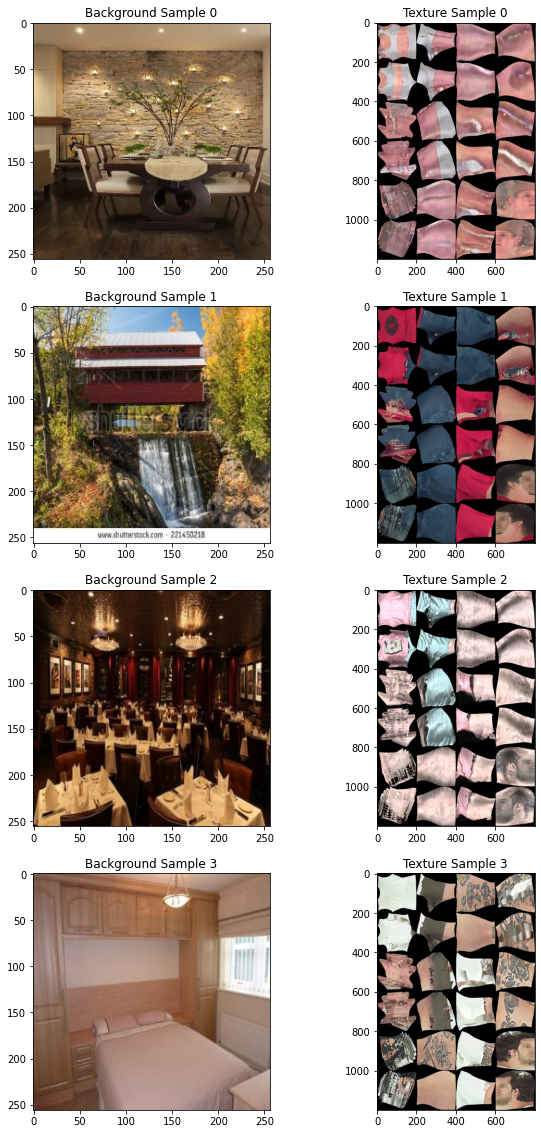

In [11]:
if verbosity > 1:
    batch_size = batch['pose'].shape[0]
    fig, axs = plt.subplots(batch_size, 2, figsize=(10,20))
    for idx in range(batch_size):
        axs[idx, 0].imshow(backgrounds[idx].permute(1,2,0).cpu())
        axs[idx, 1].imshow(textures[idx].cpu())
        axs[idx, 0].set_title(f"Background Sample {idx}")
        axs[idx, 1].set_title(f"Texture Sample {idx}")
    fig.show()

## Convert Axis-Angle Representation to Rotation Matrices

In [12]:
target_poses_rotmats = batch_rodrigues(target_poses.contiguous().view(-1, 3)).view(-1, 24, 3, 3)
# first entry is global orientation
target_glob_rotmats = target_poses_rotmats[:, 0, :, :]
target_poses_rotmats = target_poses_rotmats[:, 1:, :, :]
if verbosity > 1:
    print(f"Poses rotation matrices: {target_poses_rotmats.shape}")
    print(f"Global rotation matrix: {target_glob_rotmats.shape}")

Poses rotation matrices: torch.Size([4, 23, 3, 3])
Global rotation matrix: torch.Size([4, 3, 3])


## Flip Pose Targets such that they are right way up in 3D space
Flipping pose targets such that they are right way up in 3D space - i.e. wrong way up when projected <br>
Then pose predictions will also be right way up in 3D space - network doesn't need to learn to flip.

In [13]:
_, target_glob_rotmats = aa_rotate_rotmats_pytorch3d(
    rotmats=target_glob_rotmats,
    angles=np.pi,
    axes=x_axis,
    rot_mult_order='post'
)

## Compute Target Vertices and Joints

In [14]:
target_smpl_output = smpl_model(
    body_pose=target_poses_rotmats,
    global_orient=target_glob_rotmats.unsqueeze(1),
    betas=target_shapes,
    pose2rot=False
)
target_vertices = target_smpl_output.vertices
target_joints_all = target_smpl_output.joints
target_joints_h36m = target_joints_all[:, ALL_JOINTS_TO_H36M_MAP, :]
target_joints_h36mlsp = target_joints_h36m[:, H36M_TO_J14, :]
if verbosity > 1:
    print(f"Vertices: {target_vertices.shape}")
    print(f"All joints: {target_joints_all.shape}")
    print(f"Human3.6M joints: {target_joints_h36m.shape}")
    print(f"Human3.6M LSP joints: {target_joints_h36mlsp.shape}")
    
target_reposed_vertices = smpl_model(
    body_pose=torch.zeros_like(target_poses)[:, 3:], # Removes global orientation
    global_orient=torch.zeros_like(target_poses)[:, :3],
    betas=target_shapes    
).vertices
if verbosity > 1:
    print(f"Reposed vertices: {target_reposed_vertices.shape}")

Vertices: torch.Size([4, 6890, 3])
All joints: torch.Size([4, 90, 3])
Human3.6M joints: torch.Size([4, 17, 3])
Human3.6M LSP joints: torch.Size([4, 14, 3])
Reposed vertices: torch.Size([4, 6890, 3])


## Prepare Data for Rendering
Pose targets were flipped such that they are right way up in 3D space - i.e. wrong way up when projected <br>
Need to flip target_vertices_for_rendering 180° about x-axis so they are right way up when projected <br>
Need to flip target_joints_coco 180° about x-axis so they are right way up when projected

In [15]:
target_vertices_for_rendering = aa_rotate_translate_points_pytorch3d(
    points=target_vertices,
    axes=x_axis,
    angles=np.pi,
    translations=torch.zeros(3, device=device).float()
)
target_joints_coco = aa_rotate_translate_points_pytorch3d(
    points=target_joints_all[:, ALL_JOINTS_TO_COCO_MAP, :],
    axes=x_axis,
    angles=np.pi,
    translations=torch.zeros(3, device=device).float()
)
target_joints2d_coco = perspective_project_torch(
    target_joints_coco,
    None,
    target_cam_t,
    focal_length=pose_shape_cfg.TRAIN.SYNTH_DATA.FOCAL_LENGTH,
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE
)
# Check if joints within image dimensions before cropping + recentering.
target_joints2d_visib_coco = check_joints2d_visibility_torch(
    target_joints2d_coco,
    pose_shape_cfg.DATA.PROXY_REP_SIZE
)
if verbosity > 1:
    print(f"Vertices for rendering: {target_vertices_for_rendering.shape}")
    print(f"COCO joints: {target_joints_coco.shape}")
    print(f"COCO 2D joints: {target_joints2d_coco.shape}")
    print(f"2D joints visible: {target_joints2d_visib_coco.shape}")

Vertices for rendering: torch.Size([4, 6890, 3])
COCO joints: torch.Size([4, 17, 3])
COCO 2D joints: torch.Size([4, 17, 2])
2D joints visible: torch.Size([4, 17])


## Setup Lighting

In [16]:
lights_rgb_settings = augment_light(
    batch_size=1,
    device=device,
    rgb_augment_config=pose_shape_cfg.TRAIN.SYNTH_DATA.AUGMENT.RGB
)
print(lights_rgb_settings)

{'location': tensor([[-0.8615,  0.8654, -1.1589]], device='cuda:0'), 'ambient_color': tensor([[0.7225, 0.7225, 0.7225]], device='cuda:0'), 'diffuse_color': tensor([[0.4108, 0.4108, 0.4108]], device='cuda:0'), 'specular_color': tensor([[0.3460, 0.3460, 0.3460]], device='cuda:0')}


In [17]:
renderer_output = pytorch3d_renderer(
    vertices=target_vertices_for_rendering,
    textures=textures,
    cam_t=target_cam_t,
    lights_rgb_settings=lights_rgb_settings
)

pytorch3d_textured_renderer.TexturedIUVRenderer::meshes_iuv: 
pytorch3d_textured_renderer.TexturedIUVRenderer::verts: 
tensor([[[ 1.0151e-01, -2.7496e-01,  8.1268e-03],
         [ 9.2944e-02, -2.7800e-01, -9.8800e-05],
         [ 1.4898e-02, -2.4359e-01,  9.0162e-02],
         ...,
         [ 1.9387e-01, -3.2919e-01, -8.8773e-02],
         [ 1.9474e-01, -3.2790e-01, -8.8077e-02],
         [ 1.2714e-01, -2.0836e-01, -1.4316e-01]],

        [[-4.5494e-02, -2.2854e-01, -2.3113e-01],
         [-3.9949e-02, -2.3173e-01, -2.2685e-01],
         [-5.7960e-03, -1.5138e-01, -3.0460e-01],
         ...,
         [-9.4029e-02, -3.7530e-01, -1.9594e-01],
         [-9.5202e-02, -3.7413e-01, -1.9576e-01],
         [-9.7132e-02, -3.0493e-01, -6.5900e-02]],

        [[ 5.7725e-02, -2.2877e-01, -1.0426e-01],
         [ 4.3543e-02, -2.2942e-01, -1.0702e-01],
         [ 4.2672e-02, -2.0439e-01, -8.4075e-03],
         ...,
         [ 2.5488e-02, -3.1406e-01, -2.2774e-01],
         [ 2.6085e-02, -3.1310e-01,

## Visualize Results

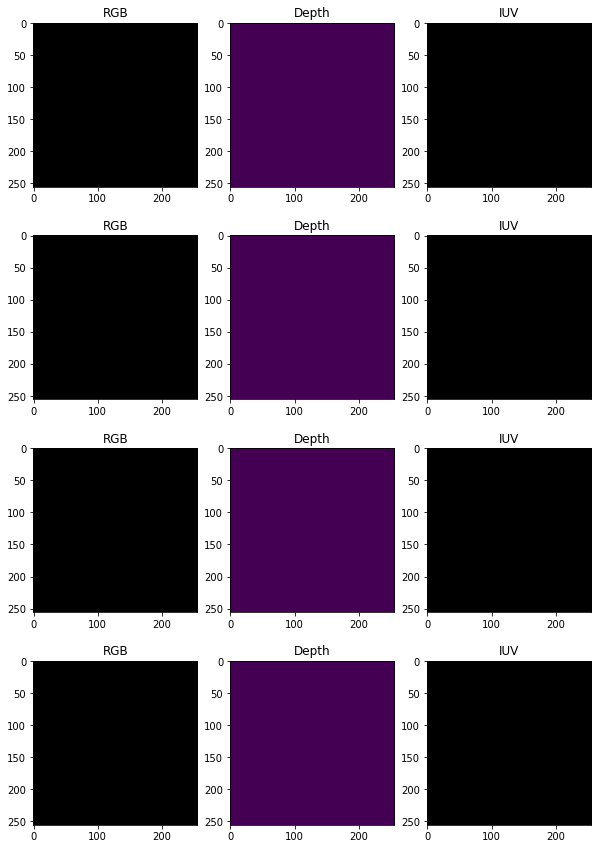

In [22]:
if verbosity > 1:
    batch_size = renderer_output['rgb_images'].shape[0]
    fig, axs = plt.subplots(batch_size, 3, figsize=(10,15))
    for idx in range(batch_size):
        axs[idx, 0].imshow(renderer_output['rgb_images'][idx].detach().cpu())
        axs[idx, 0].set_title('RGB')
        axs[idx, 1].imshow(renderer_output['depth_images'][idx].detach().cpu())
        axs[idx, 1].set_title('Depth')
        axs[idx, 2].imshow(renderer_output['iuv_images'][idx].detach().cpu())
        axs[idx, 2].set_title('IUV')
    fig.show()

# Debug Rendering

## Necessary Imports

In [19]:
from pytorch3d.structures import Meshes
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# Debug Rendering

## Create Data Structures for Mesh and Texture

In [23]:
# each vertex has 3 texture features: i (body part index), u, v
textures_iuv = TexturesVertex(verts_features=pytorch3d_renderer.verts_iuv)
# increases number of vertices from SMPL vertex indexing (0 ... 6889) to DP vertex indexing (0 ... 7828)
vertices = target_vertices_for_rendering[:, pytorch3d_renderer.verts_map, :]
meshes_iuv = Meshes(
    verts=vertices,
    faces=pytorch3d_renderer.faces_densepose,
    textures=textures_iuv
)
# texture representation
textures_rgb = TexturesUV(
    maps=textures,
    faces_uvs=pytorch3d_renderer.faces_densepose,
    verts_uvs=pytorch3d_renderer.verts_uv_offset
)
meshes_rgb = Meshes(
    verts=vertices,
    faces=pytorch3d_renderer.faces_densepose,
    textures=textures_rgb
)
if verbosity > 1:
    print(f"Textures IUV: {textures_iuv._verts_features_padded.shape}")
    print("Meshes IUV:")
    print(f"    Vertices: {meshes_iuv._verts_padded.shape}")
    print(f"    Faces: {meshes_iuv._faces_padded.shape}")
    print("Textures RGB:")
    print(f"    Faces UVs: {textures_rgb._faces_uvs_padded.shape}") # for each face, indices into verts_uvs
    print(f"    Verts UVs: {textures_rgb._verts_uvs_padded.shape}") # per-vertex uv coordinates
    print(f"    Maps: {textures_rgb._maps_padded.shape}")
    print("Meshes RGB:")
    print(f"    Verts: {meshes_rgb._verts_padded.shape}")
    print(f"    Faces: {meshes_rgb._faces_padded.shape}")

Textures IUV: torch.Size([4, 7829, 3])
Meshes IUV:
    Vertices: torch.Size([4, 7829, 3])
    Faces: torch.Size([4, 13774, 3])
Textures RGB:
    Faces UVs: torch.Size([4, 13774, 3])
    Verts UVs: torch.Size([4, 7829, 2])
    Maps: torch.Size([4, 1200, 800, 3])
Meshes RGB:
    Verts: torch.Size([4, 7829, 3])
    Faces: torch.Size([4, 13774, 3])


## Save Meshes

In [74]:
for idx in range(meshes_rgb._N):
    IO().save_mesh(
        data=meshes_rgb[idx],
        path=f"/garmentor/output/mesh_rgb_{idx}.obj"
    )
    IO().save_mesh(
        data=meshes_iuv[idx],
        path=f"/garmentor/output/mesh_iuv_{idx}.obj"
    )
! chmod -R a+rw /garmentor/output

Data structures and meshes look ok

## Rasterizer

In [77]:
vars(pytorch3d_renderer.cameras)

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'device': device(type='cuda', index=0),
 '_N': 4,
 'K': None,
 '_in_ndc': True,
 'focal_length': tensor([[300., 300.],
         [300., 300.],
         [300., 300.],
         [300., 300.]], device='cuda:0'),
 'principal_point': tensor([[128., 128.],
         [128., 128.],
         [128., 128.],
         [128., 128.]], device='cuda:0'),
 'R': tensor([[[-1.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0.,  1.]],
 
         [[-1.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0.,  1.]],
 
         [[-1.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0.,  1.]],
 
         [[-1.,  0.,  0.],
          

In [95]:
torch.eye(3).unsqueeze(0).repeat(4,1,1).shape

torch.Size([4, 3, 3])

In [ ]:
torch.eye(3).reshape(1, 3, 3).repeat

In [98]:
#pytorch3d_renderer.cameras.R = torch.eye(3).unsqueeze(0).repeat(4,1,1).to(device)

In [99]:
fragments = pytorch3d_renderer.rasterizer(meshes_iuv, cameras=pytorch3d_renderer.cameras)
zbuffers = fragments.zbuf[:, :, :, 0]
if verbosity > 1:
    print(f"Pix_to_face: {fragments.pix_to_face.shape}")
    print(f"Z Buffer: {zbuffers.shape}")
    print(f"Barycentric Coordinates: {fragments.bary_coords.shape}")
    print(f"Distances: {fragments.dists.shape}")

Pix_to_face: torch.Size([4, 256, 256, 1])
Z Buffer: torch.Size([4, 256, 256])
Barycentric Coordinates: torch.Size([4, 256, 256, 1, 3])
Distances: torch.Size([4, 256, 256, 1])


Problem lies with rasterizer

In [100]:
zbuffers

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1

In [51]:
vars(meshes_iuv)

{'device': device(type='cuda', index=0),
 'textures': <pytorch3d.renderer.mesh.textures.TexturesVertex at 0x7ff2144261c0>,
 'equisized': True,
 'valid': tensor([True, True, True, True], device='cuda:0'),
 '_N': 4,
 '_V': 7829,
 '_F': 13774,
 '_verts_list': None,
 '_faces_list': None,
 '_verts_packed': None,
 '_verts_packed_to_mesh_idx': None,
 '_verts_padded_to_packed_idx': None,
 '_mesh_to_verts_packed_first_idx': None,
 '_faces_packed': None,
 '_faces_packed_to_mesh_idx': None,
 '_mesh_to_faces_packed_first_idx': None,
 '_edges_packed': None,
 '_edges_packed_to_mesh_idx': None,
 '_num_edges_per_mesh': None,
 '_mesh_to_edges_packed_first_idx': None,
 '_faces_packed_to_edges_packed': None,
 '_verts_padded': tensor([[[ 1.0151e-01, -2.7496e-01,  8.1268e-03],
          [ 9.2944e-02, -2.7800e-01, -9.8800e-05],
          [ 1.4898e-02, -2.4359e-01,  9.0162e-02],
          ...,
          [ 1.9387e-01, -3.2919e-01, -8.8773e-02],
          [ 1.9474e-01, -3.2790e-01, -8.8077e-02],
          [ 1.

In [36]:
fragments.pix_to_face.shape

torch.Size([4, 256, 256, 1])

In [45]:
torch.unique(zbuffers)

tensor([-1.], device='cuda:0', grad_fn=<Unique2Backward0>)

In [48]:
fragments.bary_coords

tensor([[[[[-1., -1., -1.]],

          [[-1., -1., -1.]],

          [[-1., -1., -1.]],

          ...,

          [[-1., -1., -1.]],

          [[-1., -1., -1.]],

          [[-1., -1., -1.]]],


         [[[-1., -1., -1.]],

          [[-1., -1., -1.]],

          [[-1., -1., -1.]],

          ...,

          [[-1., -1., -1.]],

          [[-1., -1., -1.]],

          [[-1., -1., -1.]]],


         [[[-1., -1., -1.]],

          [[-1., -1., -1.]],

          [[-1., -1., -1.]],

          ...,

          [[-1., -1., -1.]],

          [[-1., -1., -1.]],

          [[-1., -1., -1.]]],


         ...,


         [[[-1., -1., -1.]],

          [[-1., -1., -1.]],

          [[-1., -1., -1.]],

          ...,

          [[-1., -1., -1.]],

          [[-1., -1., -1.]],

          [[-1., -1., -1.]]],


         [[[-1., -1., -1.]],

          [[-1., -1., -1.]],

          [[-1., -1., -1.]],

          ...,

          [[-1., -1., -1.]],

          [[-1., -1., -1.]],

          [[-1., -1., -1.]

In [50]:
fragments.dists

tensor([-1.], device='cuda:0', grad_fn=<Unique2Backward0>)